# Ford GoBike System Data Exploration
## by Luca(MingCong) Zhou

## Preliminary Wrangling

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

In [96]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from folium import plugins
import requests
from io import StringIO
from geopy.distance import distance
from IPython.display import Image
import geopandas as gpd
import folium
import json
import os

%matplotlib inline
%config Completer.use_jedi = False

In [20]:
# Since GitHub does not allow for large file, I decided loading the data from an url
file_url = "https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv"
res = requests.get(file_url)

In [21]:
# load the bytes data into pandas dataframe if status code is 200
if res.status_code != requests.codes.ok:
    print("Download Failed!")

s = str(res.content, 'utf-8')
data = StringIO(s)
df = pd.read_csv(data)

In [22]:
# high-level overview of data shape and composition
df.sample()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
52303,398,2019-02-21 17:20:52.2200,2019-02-21 17:27:30.4370,88.0,11th St at Bryant St,37.77003,-122.411726,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,5229,Subscriber,1989.0,Female,No


In [23]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(183412, 16)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object
duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                    

### Issues

#### Issue 1 Missing Values

1. 197 values are missing for features: start_station_id, start_station_name.
2. 8265 values are missing for features: member_birth_year and member_gender.

#### Solve Issue 1

In [24]:
# drop the rows with null values
df.dropna(inplace=True)

#### Issue 2 Misused Data Types

1. start_time, and end_time columns are in string format.
2. start_station_id, and member_birth_year columns are in float format.

#### Solve Issue 2

In [25]:
# convert the 'start_time' and 'end_time' columns to datetime format
df['start_time']= pd.to_datetime(df['start_time'])
df['end_time']= pd.to_datetime(df['end_time'])

# convert the 'start_station_id' and 'member_birth_year columns to int format
df['start_station_id'] = df['start_station_id'].astype('int')
df['member_birth_year'] = df['member_birth_year'].astype('int')

#### Inspect the cleaned dataframe

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_id         174952 non-null  int64         
 4   start_station_name       174952 non-null  object        
 5   start_station_latitude   174952 non-null  float64       
 6   start_station_longitude  174952 non-null  float64       
 7   end_station_id           174952 non-null  float64       
 8   end_station_name         174952 non-null  object        
 9   end_station_latitude     174952 non-null  float64       
 10  end_station_longitude    174952 non-null  float64       
 11  bike_id                  174952 non-null  int64         
 12  user_type       

### What is the structure of your dataset?

There are 183412 rides in the dataset with 16 features (``duration_sec``, ``start_time``, ``end_time``, ``start_station_id``, ``start_station_name``, ``start_station_latitude``, ``start_station_longitude``, ``end_station_id``, ``end_station_name``, ``end_station_latitude``, ``end_station_longitude``, ``bike_id``, ``user_type``, ``member_birth_year``, ``member_gender``, and ``bike_share_for_all_trip``). 

Most variables are numeric in nature, but the variables ``start_station_name``, ``end_station_name``, ``user_type``, ``member_gender`` and ``bike_share_for_all_trip`` are nominal factor variables.

### What is/are the main feature(s) of interest in your dataset?

I am most interested in figuring out what factors can increase the usage of our shared bicycle.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that the amount of bike usage depends on the following factors:

1. the time of the day and the day of the week.
2. the location of the bike station.
3. the age of the user.
4. the gender of the user.

## Univariate Exploration

Our goal is to figure out what factors can increase our bike usage. 

I will start by looking at the distance people traveled when they are using our bicycles.

### How far do people usually bike when they are using our shared bicycles?

To get the distance of rides, we need to know the starting and ending locations. The features ``start_station_latitude``, ``start_station_longitude``, ``end_station_latitude``, and ``end_station_longitude`` are provided in the datasets. These features are two GPS coordinates:

```text
                                        |
                                        |   (x1,y1)
                                        |
                                        |
                                        |                        (x2, y2)
                                --------|-----------------------------------------
                                        |
```

Remember, from high school, to find the distance between two coordinates, we can use [Euclid's theorem](https://en.wikipedia.org/wiki/Euclid's_theorem). Nevertheless, since Earth is a sphere, we can not directly apply the theorem here. However, Python has made everything so easy for us. We will use the [geopy](https://github.com/geopy/geopy) library to solve the problem.

In [27]:
# use geopy to measure distances, store it as a new feature
# for your reference: https://geopy.readthedocs.io/en/stable/#module-geopy.distance
def getDistance(startCoord, endCoord):
    """
    This function will return the distance (in km) between two coordinates.

    :param[float tuple] startCoord the starting coordinate
    :param[float tuple] endCoord the ending coordinate
    :return float, the distance between two coordinates
    """
    return distance(startCoord, endCoord).km

In [28]:
distances = list()

# calculate distance for all rows
for ride in df.itertuples():
    startCoord = (ride.start_station_latitude, ride.start_station_longitude)
    endCoord = (ride.end_station_latitude, ride.end_station_longitude)
    distances.append(getDistance(startCoord, endCoord))

df['distance'] = distances

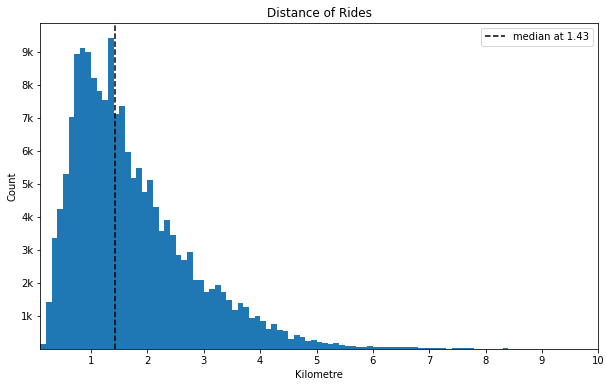

In [29]:
# start with distance
plt.figure(figsize=[10, 6])

bins = np.arange(0, 10 + 0.1, 0.1)

plt.hist(data=df, x='distance', bins= bins)

# add ticks for x axis
xticks = np.arange(0, 10 + 1, 1)
plt.xticks(xticks)

# add ticks for y axis
yticks = np.arange(1000, 10000, 1000)
ylabel = ['{}k'.format(el // 1000) for el in yticks]
plt.yticks(yticks, ylabel)

# zoom in. there are outliers in the df
plt.xlim([0.1, 10])

# add title and label
plt.title("Distance of Rides")
plt.xlabel("Kilometre")
plt.ylabel("Count")

# add a vertical line for median
med = df.distance.median()
plt.axvline(x=med, color='k', linestyle='--', label="median at {:.2f}".format(med))

plt.legend()

plt.show()

Since the ``distance`` feature is a quantitative continuous variable, a histogram can be applied for its visualization. As we can see on the above graph, there are a few peaks and valleys; Yet there are two main ones. Therefore, it is a **bimodal histogram**. 

A vertical line that represents the median has been added to the graph. The line tells us **half of our users choose to use our shared bicycles when the trip is less than 1.43 kilometers**. As the distance increases, the user's count using the shared bicycles gradually decreases on the vertical line's right. Therefore, the ``distance`` feature has a **right-skewed** distribution. By analogy, **people tend to move out from our shared bicycles when the distance to a location is more significant than 1.43 kilometers**.

During the building of the above visulization, some surprises on the dataset were found.

1. As we can see in the data frame below, this lady biked 70 kilometers in 1.93 hours. The calculated time is around 5 hours and 19 minutes on Google Map for this trip. The event should consider as a miracle for her.

In [30]:
df.query("distance >= 69")[['start_station_name', 'end_station_name', 'member_gender', 'distance', 'duration_sec']]

,start_station_name,end_station_name,member_gender,distance,duration_sec
112038,Montgomery St BART Station (Market St at 2nd St),Palm St at Willow St,Female,69.465977,6945


Since the above row's distance is a bias, the above graph has zoomed in to display most of the data points.

2. Another unique point occurs when the distance is zero. About 3.5K rides ended at the same position; The starting point is the same as the ending point. Since we cannot track the distance when the two points are the same, the above graph has set the starting ticks as 0.1 using the ``xlim`` method.

We have seen how the distribution of the distance is plotted. A quick insight from the graph is **most people would consider using our bikes when the location is not too far away**. However, some rows' **starting and ending location data are the same** (mentioned on point 2, above). We should also look at the average duration people spend on our bikes.

### How long does the average trip take?

As well as inspecting the distance people travel, the duration of bike usage is also a valuable indicator. Observing the histogram above shows some outliers; for instance, some rows' starting and ending location data are the same. However, are they regret it immediately after they rent a bike? The following is a histogram that demonstrates the distribution of the duration.

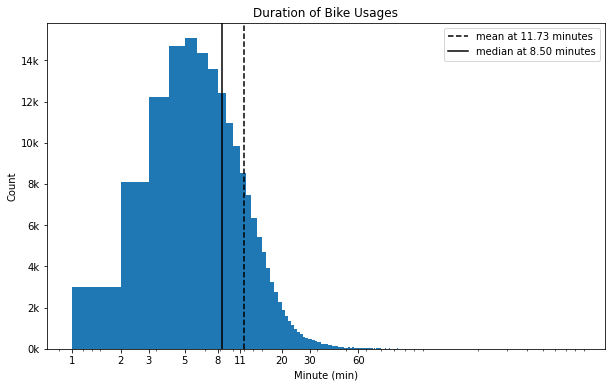

In [31]:
plt.figure(figsize=[10, 6])

bins = np.arange(60, df.duration_sec.max() + 60, 60)
plt.hist(data=df, x='duration_sec', bins=bins)
plt.xscale("log")

ticks = [60, 120, 180, 300, 480, 660, 1200, 1800, 3600]
label = [1, 2, 3, 5, 8, 11, 20, 30, 60]
plt.xticks(ticks, label)

# add ticks for y axis
yticks = np.arange(0, 14000 + 2000, 2000)
ylabel = ['{}k'.format(el // 1000) for el in yticks]
plt.yticks(yticks, ylabel)

# add a vertical line for mean, and median
mean = df.duration_sec.mean()
med = df.duration_sec.median()
plt.axvline(x=mean, color='k', linestyle='--', label="mean at {:.2f} minutes".format(mean / 60))
plt.axvline(x=med, color='k', linestyle='solid', label="median at {:.2f} minutes".format(med / 60))
plt.legend()

plt.title("Duration of Bike Usages")
plt.xlabel("Minute (min)")
plt.ylabel("Count")

plt.show()

We are interested in the average duration of a trip. Here is the feature related to the duration in the data frame: 

* ``duration_sec``: duration in seconds.

As shown in the figure, the distribution of the plot is **right-skewed** and **unimodal**. Two vertical lines represent the mean, and the median has been added to the plot. The median suggested that **half of the rides were done in no more than 8.5 minutes**, while the **average among all trips is 11.73 minutes**. 

A quick insight from the above two graphs suggests that our shared bicycles enjoy good sales on a quick and short journey. In other words, one of the main factors that determine customers to use our bicycles is the **specific location of the bicycle**. 

However, before we dive into the location factor, let us look at when all bike usages happen.

### When are most trips taken in terms of the time of the day?

We have covered two features, ``distance`` and ``duration``. Moreover, we also gain a quick insight: most people will choose our bikes for a quick and short journey. The following bar chart liked histogram will demonstrate when all trips happened. 

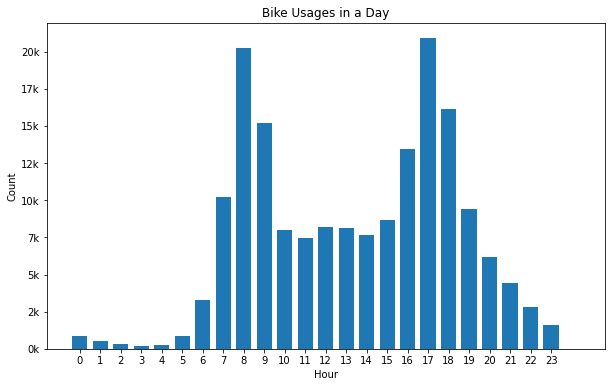

In [32]:
plt.figure(figsize=[10, 6])

bin_edges = np.arange(-0.5, 24.5 + 1, 1)
plt.hist(df.start_time.dt.hour, bins=bin_edges, rwidth=0.75)

xticks = np.arange(0, 24, 1)
plt.xticks(xticks)

# add ticks for y axis
yticks = np.arange(0, 20000 + 2500, 2500)
ylabel = ['{}k'.format(el // 1000) for el in yticks]
plt.yticks(yticks, ylabel)

plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Bike Usages in a Day")

plt.show()

Time can either be **categorical** or **quantitative**, depending on our condition (hours, seasons, and years). Since we are interested in bike usages in terms of the day, we will group time in terms of hours. Since the condition is discrete, each hour is representing as a bar on the graph. 

As we can see in the above figure, the distribution of the variable is **bimodal**. The figure also suggests that **the majority of bike usages occur during the daytime**, while there were significant usages in two time periods included:

* 7:00 am - 9:00 am.
* 4:00 pm - 6:00 pm.

Do all days in a week have the same distribution as the above graph? In common sense, 7:00 am to 9:00, and 4:00 pm to 6:00 pm are our commuter time. Is our bikes the main transportation for a commuter? We cannot tell since the data frame does not have enough useful information.

## Bivariate Exploration

To confirm whether our customers are mostly office workers, we need to compare the performance of each day of the week.

### Is the distribution of hourly bike usage the same for all days of the week?

In [34]:
df['hour'] = df.start_time.dt.hour
df['day_name'] = df.start_time.dt.day_name()

# Convert the ``day_name``j column from a plaion object type into an ordered categforical type
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = pd.api.types.CategoricalDtype(ordered=True, categories=days)
df['day_name'] = df['day_name'].astype(days)

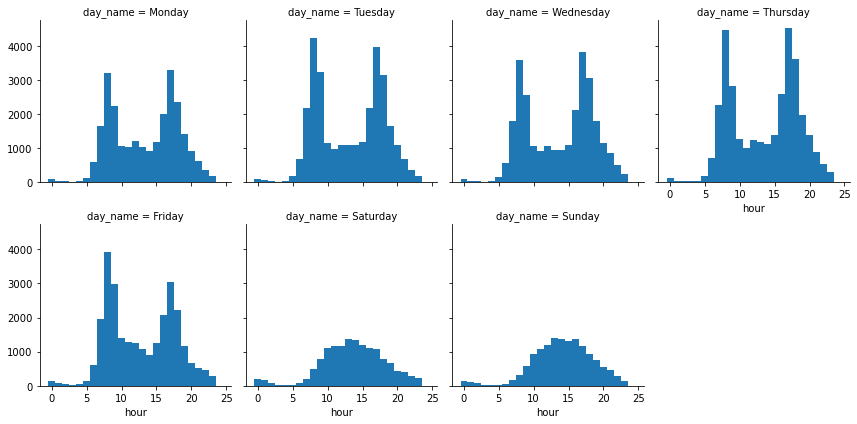

In [35]:
g = sns.FacetGrid(data=df, col="day_name", col_wrap=4, margin_titles=True)
g.map(plt.hist, 'hour', bins=bin_edges);

The answer is no. As we can see on the above graphs, the distribution is very similar for all weekdays - a **bimodal distribution** (like what we observed previously). The distribution of weekends, on the other hand, is symmetric. With this in mind, the statement **"our bikes are the main transportation for commuters"** is likely to be true.  

To summarise, **our bikes are trendy for a short and quick trip, and people tend to use them for rush hours**. 

### What locations do people use our bikes?

One of the main factors that determine customers to use our bicycles is the **specific location of the bicycle**. However, where should we place all our bikes? To solve this problem, we need to know where are all the bike usages coming from.

In [36]:
# Bounding Box is the area defined by two longitudes and two latitudes that will include all spatial points.
BBox = (df.start_station_longitude.min(), df.start_station_longitude.max(), 
        df.start_station_latitude.min(), df.start_station_latitude.max())

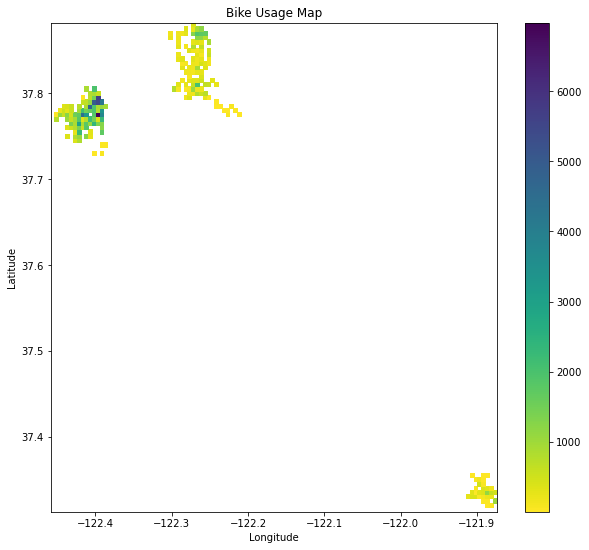

In [85]:
plt.figure(figsize=[10, 9])

bins_x = np.arange(BBox[0] - 0.005, BBox[1] + 0.005, 0.005)
bins_y = np.arange(BBox[2] - 0.005, BBox[3] + 0.005, 0.005)

plt.hist2d(data=df, x="start_station_longitude", y="start_station_latitude", cmin=0.0001, cmap="viridis_r", bins=[bins_x, bins_y]);
plt.colorbar()

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bike Usage Map")

plt.show()

<div style="padding-left: 50px;">
    
<p>

By looking at the heat map and the image below, it is clear that **most of our bike usages are coming from the modernized area; Namely, San Fransico, Berkeley, and San Jose**. The color from the graph is what we expect since most offices are located in big cities, and sometimes it is hard to find a parking lot, principally downtown.
    
In comparison to the other two cities, bike usages are more spread out for San Fransico. **Our bikes are famous for places were closer to the waterfront**. We should take a more in-depth look at bike usages for each city. 

</p>
    
<img src="./map.png" style="float: left; width: 600px;" />
</div>

#### Perform reverse geocoding using Google API

Since there is no city information for the data set, we should get it on our own. To do that, we can use the Google Map API.

In [88]:
def reverse_geocoding(lat, lng):
    """
    This function will take in two paramters longitude and latitude 
    and return the location detail for this coodinate.
    
    :param[float] lat latitude
    :param[float] lng longitude
    """
    api_key = config['GOOGLE_API_KEY']

    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = f"{base_url}?latlng={lat},{lng}&key={api_key}"

    r = requests.get(endpoint)

    results = None

    try:
        results = r.json()['results'][0]
    except:
        pass

    return results

In [87]:
# load sensitive data from file
config = json.load(open("parameters.json"))

In [93]:
# since we have limited budget, we will only reqeust 10000 rows
rides = df.sample(10000)

In [92]:
# create a list to store our json data from google api
json_data = list()

In [95]:
# request Google API and store it in a list
for ride in rides.itertuples():
    result = reverse_geocoding(ride.start_station_latitude, ride.start_station_longitude)
    json_data.append(result)

In [98]:
# save sample data to a file, since sample() return differnt rows every time
rides.to_csv("sample.csv", index=False, encoding="utf-8")

with open('./location_data.txt', 'a') as f1:
    for el in json_data:
        f1.write(str(el) + os.linesep)

In [106]:
locality = list()

for data in json_data:
    for com in data['address_components']:
        if "locality" in com["types"]:
            locality.append(com['long_name'])

rides['locality'] = locality

## Multivariate Exploration

We have found all the locality information by using the Google API. From the observations we did earlier, here are the insights we obtain so far: 

1. Most people would consider using our bikes when the trip is less than 1.43 kilometers.
2. A ride on average was done in no more than 11.73 minutes.
3. On weekdays, most bike usages occur during the daytime, and it peaked at 7 am to 9 am and 4 pm to 6 pm. While on weekends, the peak of the usages tends to shift to early afternoon.
4. Most of our bike usages was coming from the modernized area — the closer to the waterfront, the higher user density.

Everything we have considered was related to a general user. However, there are different types of users in the dataset. Different gender and age groups might have different contributions to the usage of our shared bicycles.

Let us start by looking at gender and age. Since age and gender group never showed up in the previous sections, here are two quick **univariate plots** and a bivariate plot for the two variables.

In [60]:
# calculate ages for all rows
df['age'] = 2021 - df['member_birth_year']

''

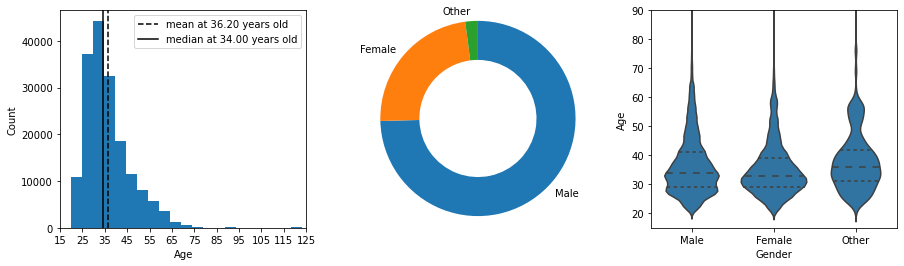

In [182]:
plt.figure(figsize=[15, 4])
base_color = sns.color_palette()[0]

plt.subplot(1, 3, 1)

plt.hist(data=df, x='age', bins=25)
plt.xticks(np.arange(15, df['age'].max() + 5, 10))

mean = df.age.mean()
med = df.age.median()
plt.axvline(x=mean, color='k', linestyle='--', label="mean at {:.2f} years old".format(mean))
plt.axvline(x=med, color='k', linestyle='solid', label="median at {:.2f} years old".format(med))
plt.legend()

plt.xlim([15, 125])

plt.xlabel("Age")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
sorted_counts = df['member_gender'].value_counts()
plt.pie(sorted_counts, labels=sorted_counts.index, startangle=90, counterclock=False, wedgeprops={"width":0.4})
plt.axis("square")

plt.subplot(1, 3, 3)
sns.violinplot(data=df, x="member_gender", y="age", color=base_color, inner="quartile", order=['Male', 'Female', 'Other'])
plt.ylim([15, 90])
plt.ylabel("Age")
plt.xlabel("Gender")
;

As shown in the left histogram, the mean is at the median's right; the age distribution is right-skewed. Moreover, the average age of a customer is 36.20 years old. From the donut chart in the middle, we can see that most of our customers are male. However, the violin plot at the right tells us females are the youngest group, followed by males and other gender groups. 

We already have a brief overview of the two features, ``age`` and ``member_gender``. Let us dine in to make our multivariate exploration.

### Is the hourly usage distribution of using the bicycles the same for each gender in a day?

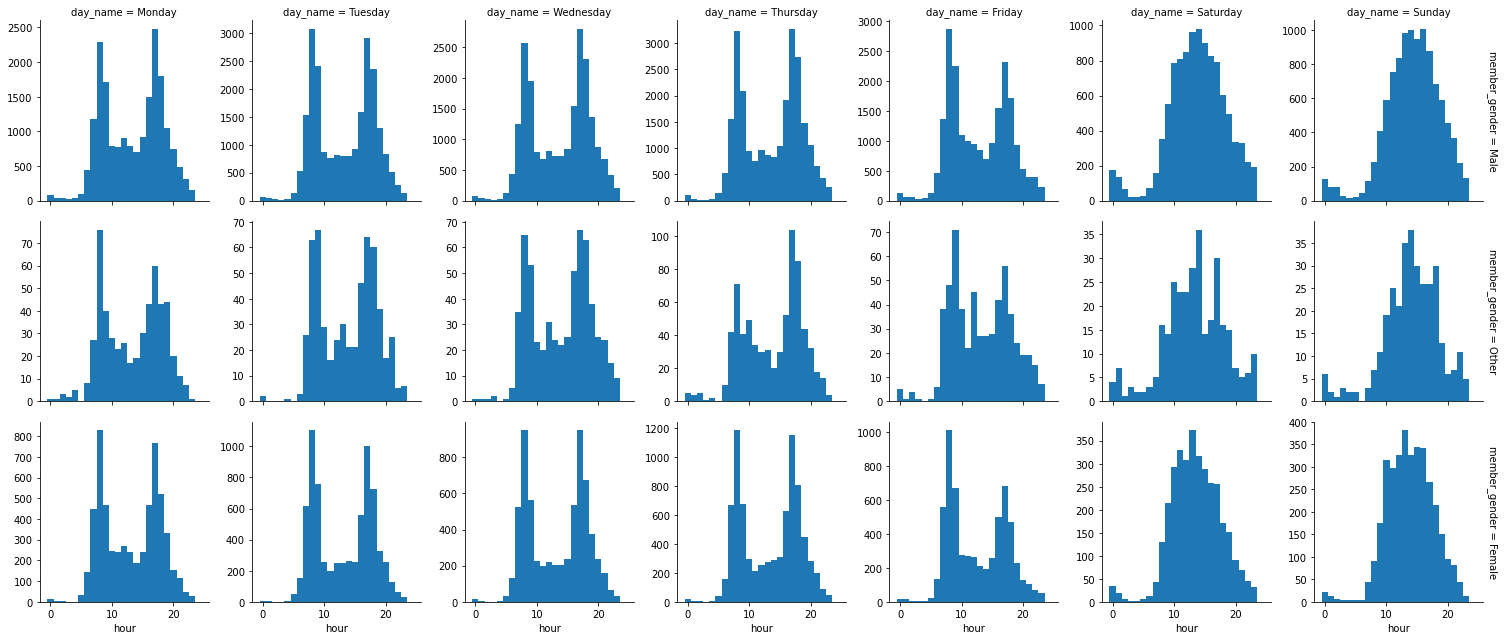

In [185]:
g = sns.FacetGrid(data=df, col="day_name", row="member_gender", margin_titles=True, sharey=False)
g.map(plt.hist, 'hour', bins=bin_edges);

Since the proportion of each gender is different, it might be helpful to turn the ``sharey`` attribute off to see the distribution. By looking at all the graphs from above, our observation we made is correct for the most part. 

> On weekdays, most bike usages occur during the daytime, and it peaked at 7 am to 9 am and 4 pm to 6 pm. While on weekends, the peak of the usages tends to shift to early afternoon.

However, when observing the usages of female users, the distribution on weekends was **multimodal** (we thought it was unimodal).

One last observation for the data frame:

## Do gender affect bike usages?

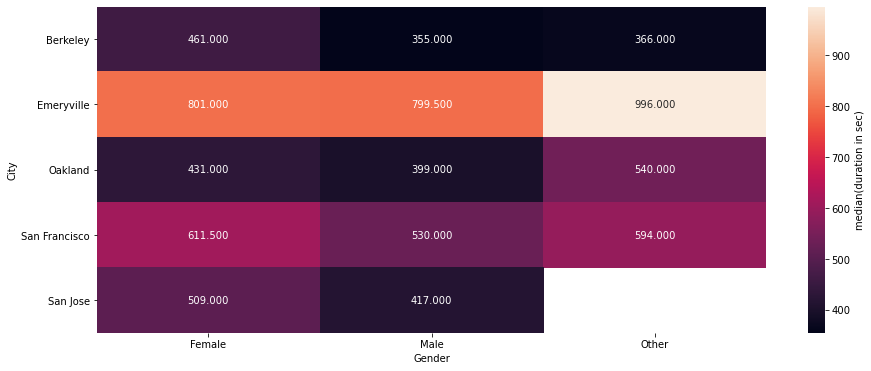

In [197]:
plt.figure(figsize=[15, 6])

cat_means = rides.groupby(["member_gender", "locality"]).median()['duration_sec']
cat_means = cat_means.reset_index(name="duration_sec_avg")
cat_means = cat_means.pivot(index="locality", columns="member_gender", values="duration_sec_avg")

sns.heatmap(cat_means, annot=True, fmt=".3f", cbar_kws={"label":"median(duration in sec)"});

plt.xlabel("Gender")
plt.ylabel("City");

Instead of using the mean to average out large values, use the median for interpretation in the above graph might be more useful. Since there are many rows and columns in the graph, it might be helpful to decode this graph in two way:

1. horizontally.
    > By looking at the graph horizontally, it is a surprise that the row with the highest median duration is Emeryville. I thought it was San Francisco since it is the largest city in this area. Good to know.
2. vertically.
    > By looking at the graph vertically, it is also a surprise that other gender groups have the most considerable median duration. I thought it was male since it is the majority gender in the data set. Good to know.


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!